## Analyse kernels in synthetic spike trains
Statistical assumptions are represented in GP kernels. With different kernels, GPFA can extract latent trajectories with variable smoothness. We will explore this with synthetic neural data with circular shaped harmonic oscillator latent dynamics.
### 1. Functions for generation of synthetic spike trains
Functions to generate synthetic spike trains are adapted from Elephant Tutorial: GPFA [link](https://elephant.readthedocs.io/en/latest/tutorials/gpfa.html)

In [1]:
import os
import numpy as np
import neo
import quantities as pq
from elephant.spike_train_generation import NonStationaryPoissonProcess

def integrated_oscillator(dt, num_steps, x0=0, y0=1, angular_frequency=2*np.pi*1e-3):
    """
    Parameters
    ----------
    dt : float
        Integration time step in ms.
    num_steps : int
        Number of integration steps -> max_time = dt*(num_steps-1).
    x0, y0 : float
        Initial values in three dimensional space.
    angular_frequency : float
        Angular frequency in 1/ms.

    Returns
    -------
    t : (num_steps) np.ndarray
        Array of timepoints
    (2, num_steps) np.ndarray
        Integrated two-dimensional trajectory (x, y, z) of the harmonic oscillator
    """

    assert isinstance(num_steps, int), "num_steps has to be integer"
    t = dt*np.arange(num_steps)
    x = x0*np.cos(angular_frequency*t) + y0*np.sin(angular_frequency*t)
    y = -x0*np.sin(angular_frequency*t) + y0*np.cos(angular_frequency*t)
    return t, np.array((x, y))

def random_projection(data, embedding_dimension, loc=0, scale=None):

    """
    Parameters
    ----------
    data : np.ndarray
        Data to embed, shape=(M, N)
    embedding_dimension : int
        Embedding dimension, dimensionality of the space to project to.
    loc : float or array_like of floats
        Mean (“centre”) of the distribution.
    scale : float or array_like of floats
        Standard deviation (spread or “width”) of the distribution.

    Returns
    -------
    np.ndarray
       Random (normal) projection of input data, shape=(dim, N)

    See Also
    --------
    np.random.normal()

    """

    if scale is None:
        scale = 1 / np.sqrt(data.shape[0])
    projection_matrix = np.random.normal(loc, scale, (embedding_dimension, data.shape[0]))
    return np.dot(projection_matrix, data)


def generate_spiketrains(instantaneous_rates, num_trials, timestep):
    """
    Parameters
    ----------
    instantaneous_rates : np.ndarray
        Array containing time series.
    timestep :
        Sample period.
    num_steps : int
        Number of timesteps -> max_time = timestep*(num_steps-1).

    Returns
    -------
    spiketrains : list of neo.SpikeTrains
        List containing spiketrains of inhomogeneous Poisson
        processes based on given instantaneous rates.

    """

    spiketrains = []
    for _ in range(num_trials):
        spiketrains_per_trial = []
        for inst_rate in instantaneous_rates:
            anasig_inst_rate = neo.AnalogSignal(inst_rate, sampling_rate=1/timestep, units=pq.Hz)
            pps = NonStationaryPoissonProcess(anasig_inst_rate,refractory_period=3*pq.ms)
            spiketrains_per_trial.append(pps.generate_spiketrain())
        spiketrains.append(spiketrains_per_trial)

    return spiketrains

### 2. Generate synthetic spike train data
Generate 38-dimensional synthetic spike train based on a trajectory of a 2-dimensional harmonic oscillator.
The synthetic dataset has the similar configuration with NaturalImages dataset experiments (the same dimensions, trail durations, number of tails, number of neurons and nearly the same mean firing rate).

In [2]:
# set parameters for the integration of the harmonic oscillator
timestep = 1 * pq.ms
trial_duration = 0.3 * pq.s
num_steps = int((trial_duration.rescale('ms')/timestep).magnitude)

# set parameters for spike train generation
max_rate = 194 * pq.Hz
np.random.seed(42)  # for visualization purposes, we want to get identical spike trains at any run

# specify data size
num_trials = 30
num_spiketrains = 38

# generate a low-dimensional trajectory
times_oscillator, oscillator_trajectory_2dim = integrated_oscillator(
    timestep.magnitude, num_steps=num_steps, x0=0, y0=1,angular_frequency=20/3*np.pi*1e-3)
times_oscillator = (times_oscillator*timestep.units).rescale('s')

# random projection to high-dimensional space
oscillator_trajectory_Ndim = random_projection(
    oscillator_trajectory_2dim, embedding_dimension=num_spiketrains,loc=1,scale=10)

# convert to instantaneous rate for Poisson process
normed_traj = oscillator_trajectory_Ndim / oscillator_trajectory_Ndim.max()
instantaneous_rates_oscillator = np.power(max_rate.magnitude, normed_traj)
# generate spike

spiketrains_oscillator = generate_spiketrains(
    instantaneous_rates_oscillator, num_trials, timestep)

### 3. Overview of generated data

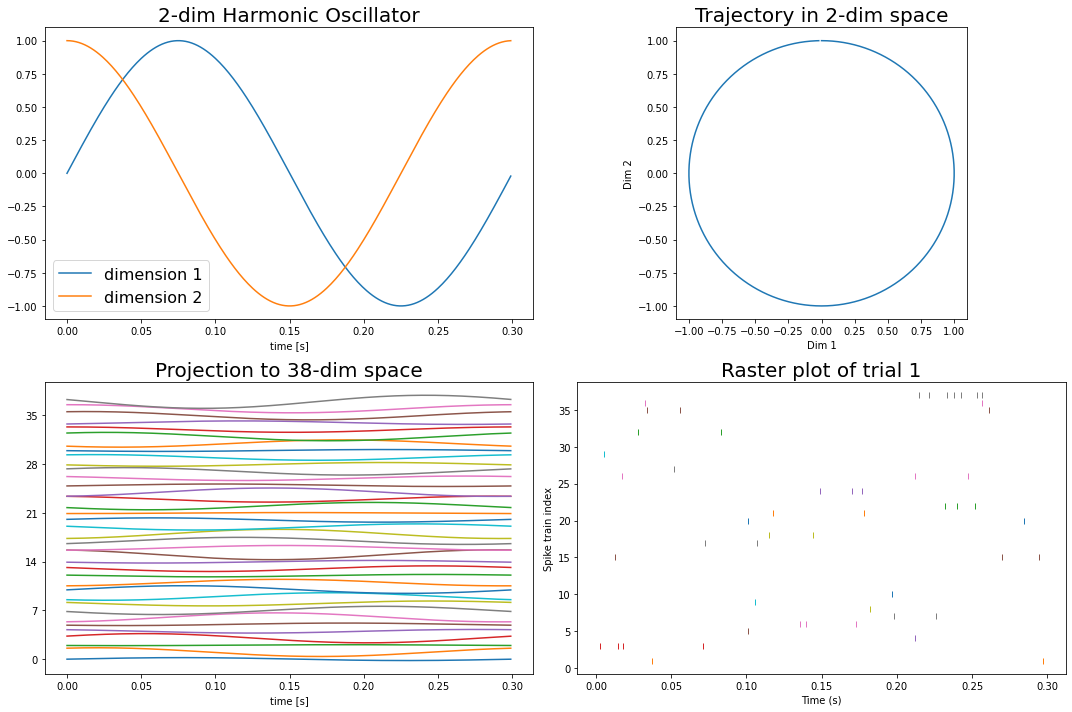

In [3]:
import matplotlib.pyplot as plt


f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

ax1.set_title('2-dim Harmonic Oscillator',fontsize=20)
ax1.set_xlabel('time [s]')
for i, y in enumerate(oscillator_trajectory_2dim):
    ax1.plot(times_oscillator, y, label=f'dimension {i+1}')
ax1.legend(prop={"size":16})

ax2.set_title('Trajectory in 2-dim space',fontsize=20)
ax2.set_xlabel('Dim 1')
ax2.set_ylabel('Dim 2')
ax2.set_aspect(1)
ax2.plot(oscillator_trajectory_2dim[0], oscillator_trajectory_2dim[1])

ax3.set_title(f'Projection to {num_spiketrains}-dim space',fontsize=20)
ax3.set_xlabel('time [s]')
offset_up_bound = 1050
y_offset = oscillator_trajectory_Ndim.std() * 3
for i, y in enumerate(oscillator_trajectory_Ndim):
    ax3.plot(times_oscillator, y+ i*y_offset)
ax3.set_yticks(np.arange(0,offset_up_bound,200),[round(i/y_offset) for i in np.arange(0,offset_up_bound,200)])
trial_to_plot = 1
ax4.set_title(f'Raster plot of trial {trial_to_plot}',fontsize=20)
ax4.set_xlabel('Time (s)')
ax4.set_ylabel('Spike train index')
for i, spiketrain in enumerate(spiketrains_oscillator[trial_to_plot]):
    ax4.plot(spiketrain, np.ones_like(spiketrain) * i, ls='', marker='|')

plt.tight_layout()
if not os.path.exists('./LatentTrajectories/HarmonicOscillator/'):
            os.makedirs('./LatentTrajectories/HarmonicOscillator/')
plt.savefig("./LatentTrajectories/HarmonicOscillator/"+'2-Dim_Harmonic_Oscillator_300ms'+'.png',dpi=600)
plt.show()

## 4. Analyse kernels on synthetic data
Extract 2D latent dynamics of synthetic data using different kernels. Figures are saved at `./LatentTrajectories/HarmonicOscillator/` .
According to the prior GP trajectories sampled from Gaussian Processes (GPs) when they adopt different kernels, those kernels can be divided into smooth and rigid kernel.
Smooth kernels usually have a concave shaped curve and a smooth turning point. Rigid kernels usually have a non-differentiable sharp middle turning point and a convex shaped curve.
triangular ,exponential and exponential times triangular kernel can be classified as rigid kernel due to its kernel curve is convex and has non-differentiable turning point.
rbf, rational quadratic, matern, spectral mixture kernel can be classified as smooth kernel where they have a everywhere differentiable kernel curve.
exponential times rational quadratic and exponential times triangular kernel are consist of one smooth kernel and one rigid kernel, they are believed have variable smoothness.

rbf and matern kernel can generate smoother trajectory than spectral mixture kernel, but sm kernel still wins on data log-likelihood.
Smooth kernels generally have better data loglikelihood. Adopting rigid kernels such as triangular kernel, GPFA tends to extract complex Trajectories.

Bayesian Optimisation is a probabilistic method which can achieve comprehensive search in wider range in enough iterations. For saving time, parameter 'bo' can be set to a lower number, and it may cause a performance drop of SM kernel.

In [4]:
from threading import Lock
from GPFA_visualisation_addons import plot_trajectories_vs_time
from concurrent.futures import ThreadPoolExecutor
from concurrent.futures import as_completed
import warnings

warnings.filterwarnings('ignore')

lock = Lock()
kernels = ['rbf','rbf_try','exp','tri','rq','matern','sm','tri_times_rq','exp_times_rq','exp_times_tri']
executor = ThreadPoolExecutor(max_workers=10)
all_task = [executor.submit(plot_trajectories_vs_time,lock,spiketrains_oscillator,{'x_dim':2, 'bin_size': 20 *pq.ms, 'covType' : kernel, 'bo': 100},[0,1]) for kernel in kernels]
for future in as_completed(all_task):
    ll_2d,f,ax1,_ = future.result()
    title = ax1.get_title()
    kernel = title.split(' ')[0]
    f.savefig('./LatentTrajectories/HarmonicOscillator/'+kernel+'.png')
    plt.close(f)

c:\users\wanghuabing\onedrive - university of edinburgh\ug4\hons_project\elephant_modified\elephant\gpfa\gpfa_util.py:133: UserWarning: trial corresponding to index 0 shorter than one segLength...skipping
  warnings.warn(
c:\users\wanghuabing\onedrive - university of edinburgh\ug4\hons_project\elephant_modified\elephant\gpfa\gpfa_util.py:133: UserWarning: trial corresponding to index 1 shorter than one segLength...skipping
  warnings.warn(
c:\users\wanghuabing\onedrive - university of edinburgh\ug4\hons_project\elephant_modified\elephant\gpfa\gpfa_util.py:133: UserWarning: trial corresponding to index 2 shorter than one segLength...skipping
  warnings.warn(
c:\users\wanghuabing\onedrive - university of edinburgh\ug4\hons_project\elephant_modified\elephant\gpfa\gpfa_util.py:133: UserWarning: trial corresponding to index 3 shorter than one segLength...skipping
  warnings.warn(
c:\users\wanghuabing\onedrive - university of edinburgh\ug4\hons_project\elephant_modified\elephant\gpfa\gpfa_ut

Initializing parameters using factor analysis...
Initializing parameters using factor analysis...
Initializing parameters using factor analysis...
Initializing parameters using factor analysis...
Initializing parameters using factor analysis...
Initializing parameters using factor analysis...
Initializing parameters using factor analysis...

Fitting GPFA model...

Fitting GPFA model...

Fitting GPFA model...

Fitting GPFA model...

Fitting GPFA model...

Fitting GPFA model...

Fitting GPFA model...


C:\Users\wanghuabing\anaconda3\envs\gpfa\lib\site-packages\sklearn\gaussian_process\_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\wanghuabing\anaconda3\envs\gpfa\lib\site-packages\sklearn\gaussian_process\_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\wanghuabing\anaconda3\envs\gpfa\lib\site-packages\sklearn\gaussian_process\_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:

Fitting has converged after 15 EM iterations.)


C:\Users\wanghuabing\anaconda3\envs\gpfa\lib\site-packages\sklearn\gaussian_process\_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\wanghuabing\anaconda3\envs\gpfa\lib\site-packages\sklearn\gaussian_process\_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\wanghuabing\anaconda3\envs\gpfa\lib\site-packages\sklearn\gaussian_process\_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:

Fitting has converged after 30 EM iterations.)


C:\Users\wanghuabing\anaconda3\envs\gpfa\lib\site-packages\sklearn\gaussian_process\_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\wanghuabing\anaconda3\envs\gpfa\lib\site-packages\sklearn\gaussian_process\_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\wanghuabing\anaconda3\envs\gpfa\lib\site-packages\sklearn\gaussian_process\_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:

Fitting has converged after 50 EM iterations.)


C:\Users\wanghuabing\anaconda3\envs\gpfa\lib\site-packages\sklearn\gaussian_process\_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\wanghuabing\anaconda3\envs\gpfa\lib\site-packages\sklearn\gaussian_process\_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\wanghuabing\anaconda3\envs\gpfa\lib\site-packages\sklearn\gaussian_process\_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:

Fitting has converged after 90 EM iterations.)


C:\Users\wanghuabing\anaconda3\envs\gpfa\lib\site-packages\sklearn\gaussian_process\_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\wanghuabing\anaconda3\envs\gpfa\lib\site-packages\sklearn\gaussian_process\_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\wanghuabing\anaconda3\envs\gpfa\lib\site-packages\sklearn\gaussian_process\_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:

Fitting has converged after 100 EM iterations.)


C:\Users\wanghuabing\anaconda3\envs\gpfa\lib\site-packages\sklearn\gaussian_process\_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\wanghuabing\anaconda3\envs\gpfa\lib\site-packages\sklearn\gaussian_process\_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\wanghuabing\anaconda3\envs\gpfa\lib\site-packages\sklearn\gaussian_process\_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:

Fitting has converged after 165 EM iterations.)


C:\Users\wanghuabing\anaconda3\envs\gpfa\lib\site-packages\sklearn\gaussian_process\_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\wanghuabing\anaconda3\envs\gpfa\lib\site-packages\sklearn\gaussian_process\_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\wanghuabing\anaconda3\envs\gpfa\lib\site-packages\sklearn\gaussian_process\_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:

Fitting has converged after 295 EM iterations.)
